Loading dataset...
Data loading took 2.65 seconds.
Train shape: (512, 3), Test shape: (128, 3)

Generating 7-mers...
K-mer generation took 0.15 seconds.

Extracting features using TF-IDF (max_features=None)...
TF-IDF vectorization took 1.09 seconds.
Train feature matrix shape: (512, 16384)
Test feature matrix shape: (128, 16384)

Encoding labels...
Number of classes: 128

Training LinearSVC with C=130 on ORIGINAL TF-IDF data...
Model training took 102.28 seconds.

Evaluating model on the original TF-IDF test set...

--- Final F1 Scores ---
Final F1 Score on Test Set (macro): 0.0662
Final F1 Score on Test Set (weighted): 0.0662

--- Starting Boundary Visualization for Top 4 Classes ---

Visualizing decision boundaries for the top 4 classes: ['1.14.14.18' '1.15.1.1' '3.6.1.23' '3.6.1.13']

Applying PCA to ORIGINAL TF-IDF features of top 4 classes to 2 components...
PCA transformation took 0.13 seconds.
Explained variance ratio by 2 components (subset): 0.1445

Creating grid and predictin

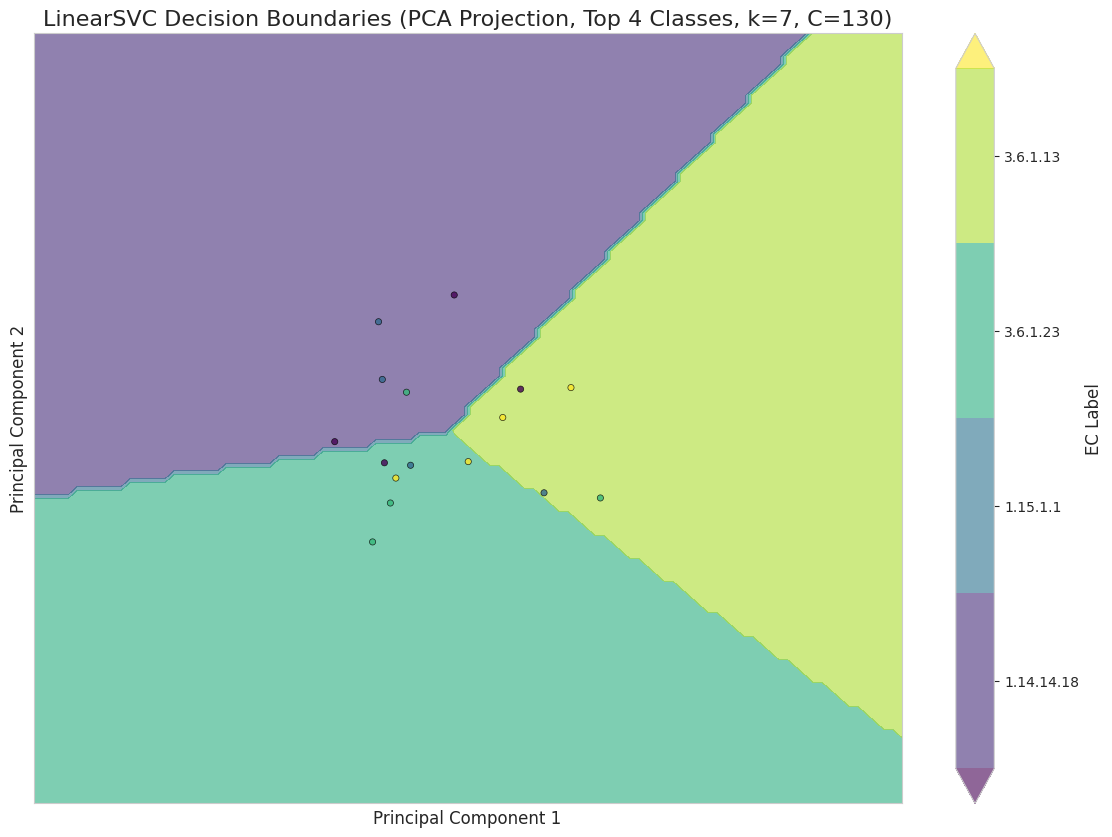


--- End of Visualizations ---
--- End of Script ---


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.auto import tqdm
import gc

# --- Configuration ---
KMER_SIZE = 7
MAX_FEATURES = None
SVM_MAX_ITER = 30000
N_JOBS = -1
PCA_N_COMPONENTS = 2
PLOT_SAMPLE_SIZE = 5000
PLOT_GRID_POINTS = 100
FIXED_C = 130

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Step 1: Load data ---
print("Loading dataset...")
start_time = time.time()
try:
    splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
    DATASET_NAME = "tattabio/ec_classification_dna"
    df_train = pd.read_parquet(f"hf://datasets/{DATASET_NAME}/" + splits["train"])
    df_test = pd.read_parquet(f"hf://datasets/{DATASET_NAME}/" + splits["test"])
except Exception as e:
    print(f"Error loading data: {e}"); exit()
print(f"Data loading took {time.time() - start_time:.2f} seconds.")
print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")
df_train.dropna(subset=['Sequence'], inplace=True)
df_test.dropna(subset=['Sequence'], inplace=True)

# --- Step 2: Preprocess sequences ---
print(f"\nGenerating {KMER_SIZE}-mers...")
start_time = time.time()
def kmerize_sequence(seq, k):
    if pd.isna(seq) or len(seq) < k: return ""
    return ' '.join([seq[i:i+k] for i in range(len(seq) - k + 1)])

df_train['kmers'] = df_train['Sequence'].apply(lambda x: kmerize_sequence(x, KMER_SIZE))
df_test['kmers'] = df_test['Sequence'].apply(lambda x: kmerize_sequence(x, KMER_SIZE))
print(f"K-mer generation took {time.time() - start_time:.2f} seconds.")

# --- Step 3: Feature extraction (TF-IDF) ---
print(f"\nExtracting features using TF-IDF (max_features={MAX_FEATURES})...")
start_time = time.time()
vectorizer = TfidfVectorizer(analyzer='word', max_features=MAX_FEATURES, ngram_range=(1, 1))
X_train_high_dim = vectorizer.fit_transform(df_train['kmers'])
X_test_high_dim = vectorizer.transform(df_test['kmers'])
print(f"TF-IDF vectorization took {time.time() - start_time:.2f} seconds.")
print(f"Train feature matrix shape: {X_train_high_dim.shape}")
print(f"Test feature matrix shape: {X_test_high_dim.shape}")

# --- Step 4: Encode labels ---
print("\nEncoding labels...")
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['Label'])
y_test = label_encoder.transform(df_test['Label'])
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

# --- Step 5: Train LinearSVC Model on ORIGINAL TF-IDF Data ---
print(f"\nTraining LinearSVC with C={FIXED_C} on ORIGINAL TF-IDF data...")
start_time_train = time.time()
best_model = LinearSVC(
    C=FIXED_C,
    class_weight='balanced',
    dual=False,
    max_iter=SVM_MAX_ITER,
    random_state=42
)
best_model.fit(X_train_high_dim, y_train)
print(f"Model training took {time.time() - start_time_train:.2f} seconds.")

# --- Step 6: Evaluate on test set & Report ONLY F1 Scores ---
print("\nEvaluating model on the original TF-IDF test set...")
y_pred = best_model.predict(X_test_high_dim)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("\n--- Final F1 Scores ---")
print(f"Final F1 Score on Test Set (macro): {f1_macro:.4f}")
print(f"Final F1 Score on Test Set (weighted): {f1_weighted:.4f}")

# --- Step 7: Dimensionality Reduction & Boundary Visualization for Top 4 Classes ---
print("\n--- Starting Boundary Visualization for Top 4 Classes ---")

# Identify the top 4 most frequent classes
top_n = min(4, num_classes)
class_counts = pd.Series(y_train).value_counts().nlargest(top_n)
top_classes_indices = class_counts.index.tolist()
top_classes_labels = label_encoder.inverse_transform(top_classes_indices)
print(f"\nVisualizing decision boundaries for the top {top_n} classes: {top_classes_labels}")

if top_n < 2:
    print("Not enough classes to visualize boundaries.")
else:
    # Filter data for the top classes
    train_indices_subset = np.isin(y_train, top_classes_indices)
    X_train_subset = X_train_high_dim[train_indices_subset]
    y_train_subset = y_train[train_indices_subset]

    # Reduce dimensions using PCA on the subset of data
    print(f"\nApplying PCA to ORIGINAL TF-IDF features of top {top_n} classes to {PCA_N_COMPONENTS} components...")
    start_time_pca = time.time()
    pca_subset = PCA(n_components=PCA_N_COMPONENTS, random_state=42)
    try:
        X_train_2d_subset = pca_subset.fit_transform(X_train_subset.toarray())
        print(f"PCA transformation took {time.time() - start_time_pca:.2f} seconds.")
        print(f"Explained variance ratio by {PCA_N_COMPONENTS} components (subset): {pca_subset.explained_variance_ratio_.sum():.4f}")
    except MemoryError:
        print("\nMemoryError converting sparse matrix for PCA (subset). Boundary plot cannot be generated.")
        exit()
    except Exception as e:
        print(f"Error during PCA (subset): {e}. Boundary plot cannot be generated.")
        exit()

    # Create Meshgrid
    print("\nCreating grid and predicting for boundary visualization (top classes)...")
    start_time_viz = time.time()
    x_min, x_max = X_train_2d_subset[:, 0].min() - 1, X_train_2d_subset[:, 0].max() + 1
    y_min, y_max = X_train_2d_subset[:, 1].min() - 1, X_train_2d_subset[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, PLOT_GRID_POINTS),
                         np.linspace(y_min, y_max, PLOT_GRID_POINTS))
    grid_points_2d = np.c_[xx.ravel(), yy.ravel()]

    try:
        # Project 2D grid points back to approximate high-dim space using the PCA fitted on the subset
        grid_points_high_dim_approx = pca_subset.inverse_transform(grid_points_2d)
        # Predict class labels using the model trained on the entire dataset
        Z_encoded = best_model.predict(grid_points_high_dim_approx)

        # Map the encoded predictions back to the subset of top class indices
        Z = np.zeros_like(Z_encoded)
        mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(top_classes_indices)}
        for i, encoded_label in enumerate(Z_encoded):
            if encoded_label in top_classes_indices:
                Z[i] = mapping[encoded_label]
            else:
                # Assign a dummy value for classes outside the top N for plotting purposes
                Z[i] = -1 # Or some other indicator

        Z = Z.reshape(xx.shape)
        print(f"Grid creation and prediction took {time.time() - start_time_viz:.2f} seconds.")

        # Plotting
        plt.figure(figsize=(14, 10))
        sns.set_style("whitegrid", {'grid.linestyle': '--'})
        cmap = plt.cm.viridis
        num_top_classes = len(top_classes_indices)
        contour = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.6, levels=np.arange(-0.5, num_top_classes + 0.5), extend='both')

        # Subsample training data for plotting on top
        plot_indices = np.random.choice(X_train_2d_subset.shape[0], min(PLOT_SAMPLE_SIZE, X_train_2d_subset.shape[0]), replace=False)
        X_train_plot = X_train_2d_subset[plot_indices]
        y_train_plot_original_encoded = y_train[train_indices_subset][plot_indices]

        # Map the original encoded labels to the index in the top_classes_indices list for consistent coloring
        y_train_plot = np.array([top_classes_indices.index(label) for label in y_train_plot_original_encoded])

        scatter = plt.scatter(X_train_plot[:, 0], X_train_plot[:, 1], c=y_train_plot,
                              cmap=cmap, s=20, alpha=0.8, edgecolor='k', linewidth=0.5)

        plt.title(f'LinearSVC Decision Boundaries (PCA Projection, Top {num_top_classes} Classes, k={KMER_SIZE}, C={FIXED_C})', fontsize=16)
        plt.xlabel('Principal Component 1', fontsize=12)
        plt.ylabel('Principal Component 2', fontsize=12)

        # Create a legend for the top classes
        cbar = plt.colorbar(contour, ticks=np.arange(num_top_classes))
        cbar.ax.set_yticklabels(top_classes_labels)
        cbar.set_label('EC Label', fontsize=12)

        plt.xlim(xx.min(), xx.max()); plt.ylim(yy.min(), yy.max())
        plt.xticks(()); plt.yticks(())
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    except Exception as e:
        print(f"\nError during boundary visualization plotting: {e}")

print("\n--- End of Visualizations ---")
print("--- End of Script ---")

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import time
import warnings
from tqdm.auto import tqdm # For progress bar
import gc # Garbage collection

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


# --- Configuration ---
MAX_SEQUENCE_LENGTH = 512 # Choose max length - smaller reduces dimensionality
SVM_MAX_ITER = 3000       # Iterations for LinearSVC
GRID_SEARCH_CV_FOLDS = 3
N_JOBS = -1

# One-Hot Encoding Mapping
# Using floats for consistency with potential downstream processing
ONE_HOT_MAP = {
    'A': np.array([1., 0., 0., 0.]),
    'C': np.array([0., 1., 0., 0.]),
    'G': np.array([0., 0., 1., 0.]),
    'T': np.array([0., 0., 0., 1.]),
    'N': np.array([0., 0., 0., 0.]) # Map N to zero vector
}
UNKNOWN_CHAR_VECTOR = np.array([0., 0., 0., 0.])
PADDING_VECTOR = np.array([0., 0., 0., 0.]) # Padding represented by zeros

# --- Step 1: Load data ---
print("Loading dataset...")
start_time = time.time()
try:
    splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
    DATASET_NAME = "tattabio/ec_classification_dna"
    df_train = pd.read_parquet(f"hf://datasets/{DATASET_NAME}/" + splits["train"])
    df_test = pd.read_parquet(f"hf://datasets/{DATASET_NAME}/" + splits["test"])
except Exception as e:
    print(f"Error loading data from {DATASET_NAME}: {e}")
    exit()
print(f"Data loading took {time.time() - start_time:.2f} seconds.")
print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")

# Drop rows with missing sequences
df_train.dropna(subset=['Sequence'], inplace=True)
df_test.dropna(subset=['Sequence'], inplace=True)


# --- Step 2: One-Hot Encoding Function ---
def one_hot_encode_sequence(sequence, max_len):
    """
    Encodes a DNA sequence using one-hot mapping and pads/truncates
    to a fixed length, then flattens.
    """
    if pd.isna(sequence):
        sequence = ""

    # Ensure uppercase
    sequence = sequence.upper()

    encoded_vectors = []
    seq_len = len(sequence)

    for i in range(max_len):
        if i < seq_len:
            base = sequence[i]
            # Get the vector or use unknown vector
            vector = ONE_HOT_MAP.get(base, UNKNOWN_CHAR_VECTOR)
        else:
            # Pad with padding vector
            vector = PADDING_VECTOR
        encoded_vectors.append(vector)

    # Flatten the list of vectors into a single 1D array
    # Shape will be (max_len * 4,)
    return np.array(encoded_vectors).flatten()

# --- Step 3: Apply Encoding ---
print(f"\nApplying One-Hot Encoding (max_len={MAX_SEQUENCE_LENGTH})...")
start_time = time.time()

# Apply the function to each sequence and stack into a numpy array
# This will create a large dense array (num_samples, max_len * 4)
X_train_list = [one_hot_encode_sequence(seq, MAX_SEQUENCE_LENGTH) for seq in tqdm(df_train['Sequence'], desc="Encoding Train")]
X_train = np.vstack(X_train_list)

X_test_list = [one_hot_encode_sequence(seq, MAX_SEQUENCE_LENGTH) for seq in tqdm(df_test['Sequence'], desc="Encoding Test")]
X_test = np.vstack(X_test_list)

print(f"One-Hot Encoding took {time.time() - start_time:.2f} seconds.")
print(f"Train feature matrix shape: {X_train.shape}") # Should be (num_samples, max_len * 4)
print(f"Test feature matrix shape: {X_test.shape}")

# Clean up intermediate lists to save memory
del X_train_list, X_test_list
gc.collect()

# --- Step 4: Encode labels ---
print("\nEncoding labels...")
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['Label'])
y_test = label_encoder.transform(df_test['Label'])
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

# --- Step 5: Grid Search for best LinearSVM ---
# LinearSVC should still work, but the high dimensionality might affect optimal C
# Check n_features vs n_samples to inform dual setting.
n_features = X_train.shape[1]
n_samples = X_train.shape[0]
# Set dual based on recommendation (False if n_samples > n_features)
dual_setting = False if n_samples > n_features else True
print(f"\nUsing dual={dual_setting} for LinearSVC (n_samples={n_samples}, n_features={n_features})")

print("\nStarting Grid Search for LinearSVC on One-Hot Features...")
start_time = time.time()

param_grid = {
    'C': [0.025,0.026,0.027,0.028,0.029], # Test a range for C
}

svm = LinearSVC(
    class_weight='balanced',
    dual=dual_setting,
    max_iter=SVM_MAX_ITER,
    random_state=42
    )

grid_search = GridSearchCV(
    svm,
    param_grid,
    cv=GRID_SEARCH_CV_FOLDS,
    scoring='f1_macro',
    verbose=2,
    n_jobs=N_JOBS
    )

# Fit on the training data
grid_search.fit(X_train, y_train)

print(f"Grid Search took {time.time() - start_time:.2f} seconds.")
print("Best Parameters found by Grid Search:", grid_search.best_params_)
print(f"Best F1 score (macro) during CV: {grid_search.best_score_:.4f}")

# --- Step 6: Evaluate on test set ---
print("\nEvaluating best model on the test set...")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print metrics
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"\n--- Final Results (One-Hot Encoding + LinearSVC) ---")
print(f"Max Sequence Length: {MAX_SEQUENCE_LENGTH}")
print(f"Feature Dimension: {X_train.shape[1]}")
print(f"Best C: {grid_search.best_params_['C']}")
print("-" * 30)
print(f"Final F1 Score on Test Set (macro): {f1_macro:.4f}")
print(f"Final F1 Score on Test Set (weighted): {f1_weighted:.4f}")
print("-" * 30)


Loading dataset...
Data loading took 1.18 seconds.
Train shape: (512, 3), Test shape: (128, 3)

Applying One-Hot Encoding (max_len=512)...


Encoding Train:   0%|          | 0/512 [00:00<?, ?it/s]

Encoding Test:   0%|          | 0/128 [00:00<?, ?it/s]

One-Hot Encoding took 0.20 seconds.
Train feature matrix shape: (512, 2048)
Test feature matrix shape: (128, 2048)

Encoding labels...
Number of classes: 128

Using dual=True for LinearSVC (n_samples=512, n_features=2048)

Starting Grid Search for LinearSVC on One-Hot Features...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Grid Search took 5.54 seconds.
Best Parameters found by Grid Search: {'C': 0.025}
Best F1 score (macro) during CV: 0.0225

Evaluating best model on the test set...

--- Final Results (One-Hot Encoding + LinearSVC) ---
Max Sequence Length: 512
Feature Dimension: 2048
Best C: 0.025
------------------------------
Final F1 Score on Test Set (macro): 0.0508
Final F1 Score on Test Set (weighted): 0.0508
------------------------------
